In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
dataset = pd.read_csv('/content/housing.csv')

dataset = dataset.dropna()
print("Here are the first five rows of the dataset: ")
dataset.head(10)

Here are the first five rows of the dataset: 


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [0]:
Y = dataset['median_house_value']

X = dataset.loc[:,'longitude':'median_income']

In [0]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.31, random_state=2003)

x_train_np = x_train.to_numpy()
y_train_np = y_train.to_numpy()

x_test_np = x_test.to_numpy()
y_test_np = y_test.to_numpy()

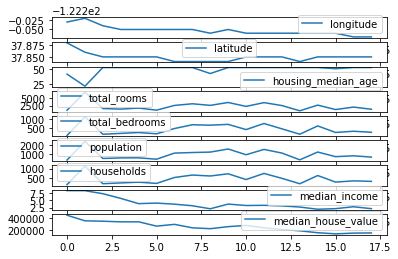

In [5]:
import matplotlib.pyplot as plt
# get columns to plot
columns = dataset.columns.drop(['ocean_proximity'])
# create x data
x_data = range(0, 18)
# create figure and axis
fig, ax = plt.subplots(9, 1)
i=0
# plot each column
for column in columns:
    ax[i].plot(x_data, dataset.head(18)[column], label=column)
    ax[i].legend()
    i=i+1


In [0]:
import torch 
from torch.nn import Conv1d

from torch.nn import MaxPool1d

from torch.nn import Flatten
from torch.nn import Linear
from torch.nn import Sequential
from torch.nn.functional import relu
from torch.utils.data import DataLoader, TensorDataset

In [0]:
class CnnRegressor(torch.nn.Module):
  def __init__(self, batch_size, inputs, outputs):
    super(CnnRegressor, self).__init__()
    self.batch_size = batch_size
    self.inputs = inputs
    self.outputs = outputs

    self.input_layer = Conv1d(inputs, batch_size, 2, padding=1)

    self.max_pooling_layer = MaxPool1d(1)

    self.conv_layer = Conv1d(batch_size, 50, 1)

    self.conv_layer1 = Conv1d(batch_size, 64, 1)    

    self.flatten_layer = Flatten()

    self.non_linear_layer =  Sequential(Linear(128, 64))

    self.output_layer =  Sequential(Linear(64, outputs))

  def feed(self, input):
    input = input.reshape((self.batch_size, self.inputs, 1))

    output = relu(self.input_layer(input))

    output = relu(self.max_pooling_layer(output))

    output = relu(self.conv_layer(output))

    output = relu(self.conv_layer1(output))

    output = self.flatten_layer(output)

    output = self.non_linear_layer(output)

    output = self.output_layer(output)

    return output


In [8]:
from torch.optim import SGD

from torch.nn import L1Loss

!pip install pytorch-ignite
from ignite.contrib.metrics.regression.r2_score import R2Score

     |████████████████████████████████| 112kB 8.9MB/s 


In [9]:
batch_size = 50

model = CnnRegressor(batch_size, X.shape[1], 1)

path = "/content/1117437_1dconv_reg.pt" 
torch.save(model.state_dict(), path)
model.cuda()

CnnRegressor(
  (input_layer): Conv1d(8, 50, kernel_size=(2,), stride=(1,), padding=(1,))
  (max_pooling_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer): Conv1d(50, 50, kernel_size=(1,), stride=(1,))
  (conv_layer1): Conv1d(50, 64, kernel_size=(1,), stride=(1,))
  (flatten_layer): Flatten()
  (non_linear_layer): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
  )
  (output_layer): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [0]:
def model_loss(model, dataset, train = False, optimizer = None):
  performance = L1Loss()
  score_metric = R2Score()

  avg_loss = 0
  avg_score = 0
  count = 0

  for input, output in iter(dataset):
    predictions = model.feed(input)
    loss = performance(predictions, output)
    score_metric.update([predictions, output])
    score = score_metric.compute()

    if(train):
      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

    avg_loss += loss.item()
    avg_score += score
    count += 1
  
  return avg_loss / count, avg_score / count

In [44]:
epochs = 100

optimizer = SGD(model.parameters(), lr=1e-5)

inputs = torch.from_numpy(x_train_np).cuda().float()
outputs = torch.from_numpy(y_train_np.reshape(y_train_np.shape[0],1)).cuda().float()

tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle=True, drop_last=True)

for epoch in range(epochs):
  avg_loss, avg_r2_score = model_loss(model, loader, train=True, optimizer=optimizer)

  print("Epoch " + str(epoch + 1) + ":\n\tLoss = " + str(avg_loss) + "\n\tR^2 Score = " + str(avg_r2_score))

Epoch 1:
	Loss = 76306.87005115658
	R^2 Score = 0.23375136023654702
Epoch 2:
	Loss = 75469.30814891015
	R^2 Score = 0.2508230040881338
Epoch 3:
	Loss = 74782.95710075623
	R^2 Score = 0.2731032660464272
Epoch 4:
	Loss = 75636.79830682829
	R^2 Score = 0.2470536921221247
Epoch 5:
	Loss = 75127.09812889235
	R^2 Score = 0.23799365911531012
Epoch 6:
	Loss = 74351.08132228648
	R^2 Score = 0.2682408364400888
Epoch 7:
	Loss = 74341.89473976869
	R^2 Score = 0.2730243487327319
Epoch 8:
	Loss = 75433.39030527136
	R^2 Score = 0.2589845049401293
Epoch 9:
	Loss = 74690.22301768238
	R^2 Score = 0.2949495908438852
Epoch 10:
	Loss = 74917.93615157918
	R^2 Score = 0.2704222226620427
Epoch 11:
	Loss = 75267.89557384342
	R^2 Score = 0.2457444626032341
Epoch 12:
	Loss = 75235.91418761121
	R^2 Score = 0.2737009977007036
Epoch 13:
	Loss = 75244.37779415035
	R^2 Score = 0.24238245465444172
Epoch 14:
	Loss = 74603.28622664591
	R^2 Score = 0.2554839472208671
Epoch 15:
	Loss = 75879.14075011121
	R^2 Score = 0.236

In [45]:
inputs = torch.from_numpy(x_test_np).cuda().float()
outputs = torch.from_numpy(y_test_np.reshape(y_test_np.shape[0],1)).cuda().float()

tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle=True, drop_last=True)

avg_loss, avg_r2_score = model_loss(model, loader)
print("The model's L1 score is : " + str(avg_loss))
print("The model's R^2 score is : " + str(avg_r2_score))

The model's L1 score is : 71226.05040922618
The model's R^2 score is : 0.31743939008397704
